In [65]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import nltk
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from nltk.stem import WordNetLemmatizer
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns



import re



# Importing data

In [66]:
df = pd.read_csv("C:/Users/KEVIN/Downloads/amazon.csv")
df.head()

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,0,NaN,4,No issues.,23-07-2014,138,0,0,0,0,0.0,0.0
1,1,0mie,5,"Purchased this for my device, it worked as adv...",25-10-2013,409,0,0,0,0,0.0,0.0
2,2,1K3,4,it works as expected. I should have sprung for...,23-12-2012,715,0,0,0,0,0.0,0.0
3,3,1m2,5,This think has worked out great.Had a diff. br...,21-11-2013,382,0,0,0,0,0.0,0.0
4,4,2&amp;1/2Men,5,"Bought it with Retail Packaging, arrived legit...",13-07-2013,513,0,0,0,0,0.0,0.0


# Text data Preprocessing (Tokenization,Lowercasing,Stop Word Removal,stemming)

In [80]:
import re

def text_preprocessing(dataframe, dependent_var):
    # Ensure dependent_var is a string-like object
    if not isinstance(dataframe[dependent_var].iloc[0], str):
        dataframe[dependent_var] = dataframe[dependent_var].astype(str)

    # Remove integers
    dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: re.sub(r'\d+', '', str(x)))

    # Normalizing Case Folding - Uppercase to Lowercase
    dataframe[dependent_var] = dataframe[dependent_var].str.lower()

    # Removing Punctuation and non-alphabetic characters
    dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', str(x)))

    # # StopWords
    # sw = set(stopwords.words('english'))
    # dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: ' '.join(word for word in x.split() if word not in sw))

    # # Lemmatize
    # lemmatizer = WordNetLemmatizer()
    # dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: ' '.join(lemmatizer.lemmatize(word) for word in x.split()))

    # # Remove Rare Words
    # temp_df = pd.Series(' '.join(dataframe[dependent_var]).split()).value_counts()
    # drops = temp_df[temp_df <= 1].index
    # dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: ' '.join(word for word in x.split() if word not in drops))

    return dataframe


# Text visualisation

C:\Users\KEVIN\AppData\Local\Temp\ipykernel_4696\3324842127.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_words.values, y=top_words.index, palette='viridis')


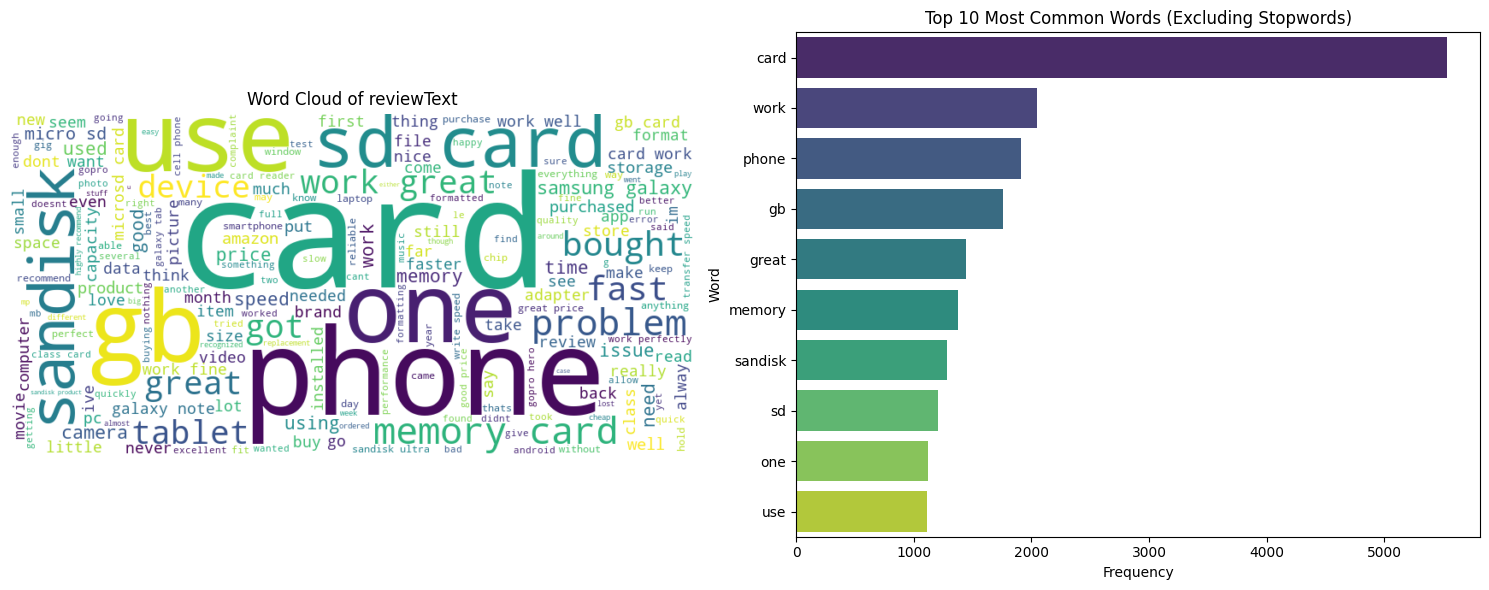

In [81]:


def visualize_text(dataframe, dependent_var):
    # Drop rows with NaN values in the specified column
    dataframe = dataframe.dropna(subset=[dependent_var])

    # Concatenate all text data into a single string
    text = ' '.join(dataframe[dependent_var].astype(str))

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Display the word cloud
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of {}'.format(dependent_var))

    # Generate bar plot for most common words excluding stopwords
    plt.subplot(1, 2, 2)
    stop_words = set(stopwords.words('english'))
    word_counts = dataframe[dependent_var].str.split(expand=True).stack().value_counts()
    top_words = word_counts[~word_counts.index.isin(stop_words)].head(10)  # Exclude stopwords
    sns.barplot(x=top_words.values, y=top_words.index, palette='viridis')
    plt.title('Top 10 Most Common Words (Excluding Stopwords)')
    plt.xlabel('Frequency')
    plt.ylabel('Word')
    plt.tight_layout()
    plt.show()

# Assuming your DataFrame is named df
visualize_text(df, 'reviewText')


# Feature selection


In [82]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import numpy as np

# Drop rows with NaN values in the reviewText column
df.dropna(subset=['reviewText'], inplace=True)

# Example review text data
sentences = df["reviewText"]

# Tokenization and preprocessing
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [token.lower() for token in tokens if token.isalnum()]
    tokens = [token for token in tokens if token not in stop_words]
    return tokens

preprocessed_texts = [preprocess_text(review_text) for review_text in sentences]

# Train Word2Vec model
w2v_model = Word2Vec(sentences=preprocessed_texts, vector_size=100, window=5, min_count=1, workers=4)

# Feature extraction
def extract_features(review_text, model):
    word_vectors = [model.wv[word] for word in review_text if word in model.wv]
    if not word_vectors:
        # If no word vectors found for any word in the text, return zeros
        return np.zeros(model.vector_size)
    # Aggregate word vectors (simple averaging)
    avg_vector = np.mean(word_vectors, axis=0)
    return avg_vector

# Extract features for each review text
features_list = []
for i, review_text in enumerate(preprocessed_texts):
    features = extract_features(review_text, w2v_model)
    features_list.append(features)
    print(f"Features for review text {i+1}: {len(features)}")


Features for review text 1: 100
Features for review text 2: 100
Features for review text 3: 100
Features for review text 4: 100
Features for review text 5: 100
Features for review text 6: 100
Features for review text 7: 100
Features for review text 8: 100
Features for review text 9: 100
Features for review text 10: 100
Features for review text 11: 100
Features for review text 12: 100
Features for review text 13: 100
Features for review text 14: 100
Features for review text 15: 100
Features for review text 16: 100
Features for review text 17: 100
Features for review text 18: 100
Features for review text 19: 100
Features for review text 20: 100
Features for review text 21: 100
Features for review text 22: 100
Features for review text 23: 100
Features for review text 24: 100
Features for review text 25: 100
Features for review text 26: 100
Features for review text 27: 100
Features for review text 28: 100
Features for review text 29: 100
Features for review text 30: 100
Features for review

# Marking sentiment label as 0s(Negative) and 1s(positive)

In [83]:
features = np.array([extract_features(review_text, w2v_model) for review_text in preprocessed_texts])
labels = np.random.randint(2, size=len(features))  # Example labels, e.g., 0 for negative, 1 for positive sentiment
threshold = 0.5  # Adjust this threshold as needed

# Create a new column 'sentiments' in the DataFrame to store sentiment labels
df['sentiments'] = df['wilson_lower_bound'].apply(lambda x: 1 if x >= threshold else 0)
df['sentiment_label'] = pd.to_numeric(df['sentiments'], errors='coerce')

# Display the DataFrame after conversion
print("\nDataFrame after converting to numeric:")
print(df)



DataFrame after converting to numeric:
      Unnamed: 0  reviewerName  overall  \
0              0           NaN        4   
1              1          0mie        5   
2              2           1K3        4   
3              3           1m2        5   
4              4  2&amp;1/2Men        5   
...          ...           ...      ...   
4910        4910        ZM "J"        1   
4911        4911            Zo        5   
4912        4912     Z S Liske        5   
4913        4913      Z Taylor        5   
4914        4914           Zza        5   

                                             reviewText  reviewTime  day_diff  \
0                                                 issue  23-07-2014       138   
1     purchased device worked advertised never much ...  25-10-2013       409   
2     work expected higher capacity think made bit e...  23-12-2012       715   
3     think worked gb card went south one held prett...  21-11-2013       382   
4     bought retail packaging arrived 

In [84]:
import pandas as pd
import numpy as np

# Load the Excel file
file_path = r"C:\Users\KEVIN\Desktop\jupyter\LOan\sentiment_labels.xlsx"

# Read the Excel file into a DataFrame
df = pd.read_excel(file_path)

# Display the DataFrame's first few rows to ensure it's loaded correctly
print(df.head())

# Convert the 'sentiment_labels' column to numeric objects
df['sentiment_label'] = pd.to_numeric(df['sentiment_label'], errors='coerce')

df.dropna(subset=['reviewText'], inplace=True)

# Drop rows with NaN values in the 'sentiment_label' column
df = df.dropna(subset=['sentiment_label'])

# Extract the 'sentiment_labels' column and convert it to a NumPy array
sentiment_labels = df['sentiment_label'].to_numpy()

# Display the extracted NumPy array
print(sentiment_labels)


   Unnamed: 0  reviewerName  overall  \
0           0           NaN        4   
1           1          0mie        5   
2           2           1K3        4   
3           3           1m2        5   
4           4  2&amp;1/2Men        5   

                                          reviewText  reviewTime  day_diff  \
0                                              issue  23-07-2014       138   
1  purchased device worked advertised never much ...  25-10-2013       409   
2  work expected higher capacity think made bit e...  23-12-2012       715   
3  think worked gb card went south one held prett...  21-11-2013       382   
4  bought retail packaging arrived legit envelope...  13-07-2013       513   

   helpful_yes  helpful_no  total_vote  score_pos_neg_diff  \
0            0           0           0                   0   
1            0           0           0                   0   
2            0           0           0                   0   
3            0           0           0    

# Feature selection

In [85]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif

# Assuming `df` is a Pandas DataFrame that has already been defined and includes a 'target' column
# Example: df = pd.read_csv('reviews.csv')

# Extract preprocessed features for each review text
features_array = np.array(features_list)  # Preprocessed features array obtained from previous steps

# Extract target variable
targets = df["sentiment_label"].tolist()

# Compute mutual information between features and target variable
mi_scores = mutual_info_classif(features_array, targets, discrete_features=False)

# Select top-k features based on mutual information scores
k = 20  # Number of top features to select
top_k_indices = np.argsort(mi_scores)[-k:]
selected_features = features_array[:, top_k_indices]

print(f"Top {k} features selected based on Improved Mutual Information (I-MI):")
print(selected_features)


Top 20 features selected based on Improved Mutual Information (I-MI):
[[-0.3497688  -0.3172387  -0.1380477  ...  0.5410557   0.02940631
   0.46255946]
 [-0.3618171  -0.26774746 -0.1000084  ...  0.41264886  0.04023618
   0.40871683]
 [-0.25934663 -0.21873693 -0.10049634 ...  0.3493755   0.03885496
   0.31186825]
 ...
 [-0.37675682 -0.19776124 -0.11220902 ...  0.3910557   0.10665983
   0.3753674 ]
 [-0.39749673 -0.3738568  -0.10751577 ...  0.46948552  0.04527256
   0.4579118 ]
 [-0.3755686  -0.23054524 -0.09459835 ...  0.41793787  0.11296927
   0.364443  ]]


# Sentiment Classification Model (80/20)


# 1 .LSTM ALGORITHM 

Epoch 1/5


C:\Users\KEVIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - accuracy: 0.7717 - loss: 0.5652 - val_accuracy: 0.8108 - val_loss: 0.4587
Epoch 2/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.8163 - loss: 0.4171 - val_accuracy: 0.8535 - val_loss: 0.3399
Epoch 3/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 0.8937 - loss: 0.2685 - val_accuracy: 0.8739 - val_loss: 0.2974
Epoch 4/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - accuracy: 0.9356 - loss: 0.1829 - val_accuracy: 0.8606 - val_loss: 0.3202
Epoch 5/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - accuracy: 0.9501 - loss: 0.1518 - val_accuracy: 0.8627 - val_loss: 0.3433
Epoch 5: early stopping
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8541 - loss: 0.3568
Test Loss: 0.3433285057544708
Test Accuracy: 0.8626652956008911
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Precision: 0.9158291457286433
Recall/Sensitivity: 0.9146800501882058
F1-Score: 0.9152542372881356
Specificity: 0.6397849462365591
MCC: 0.5533277229170582
NPV: 0.636363636363636

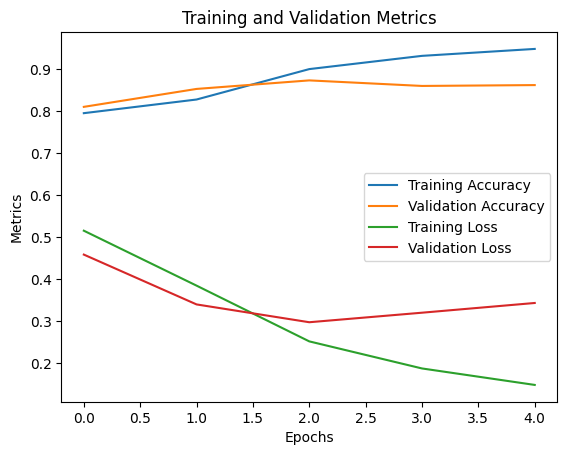

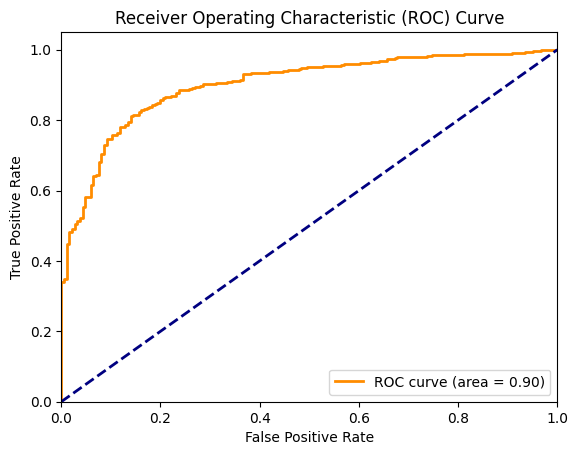

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, matthews_corrcoef
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# Prepare data for LSTM model
max_words = 10000  # Maximum number of words to be used (most frequent)
max_len = 100  # Max length of review (in words)

# Assuming `preprocessed_texts` contains preprocessed review texts and `targets` contains sentiment labels
tokenizer = Tokenizer(num_words=max_words, lower=True)
tokenizer.fit_on_texts(preprocessed_texts)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(preprocessed_texts)
padded_sequences = pad_sequences(sequences, maxlen=max_len)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, targets, test_size=0.2, random_state=42)

# Define the LSTM model
embedding_dim = 100

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_len))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])



# Train the model
batch_size = 64
epochs = 5
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

history = model.fit(X_train, np.array(y_train), 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    validation_data=(X_test, np.array(y_test)),
                    callbacks=[early_stop])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, np.array(y_test))
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

# Predictions
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Additional Metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
mcc = matthews_corrcoef(y_test, y_pred)
npv = tn / (tn + fn)
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)

print(f'Precision: {precision}')
print(f'Recall/Sensitivity: {recall}')
print(f'F1-Score: {f1}')
print(f'Specificity: {specificity}')
print(f'MCC: {mcc}')
print(f'NPV: {npv}')
print(f'FPR: {fpr}')
print(f'FNR: {fnr}')

# Plotting training/validation epochs graph
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Metrics')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


# 2. Random forest classifier

Accuracy: 0.8402848423194303
Precision: 0.850109409190372
Recall/Sensitivity: 0.9749058971141782
F1-Score: 0.9082407948568089
Specificity: 0.26344086021505375
MCC: 0.36542414320680244
NPV: 0.7101449275362319
FPR: 0.7365591397849462
FNR: 0.025094102885821833


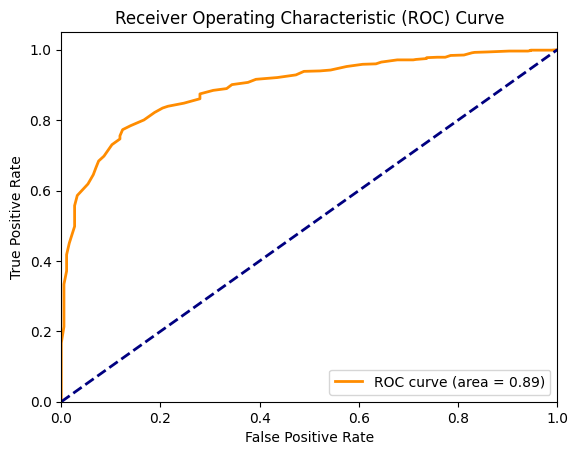

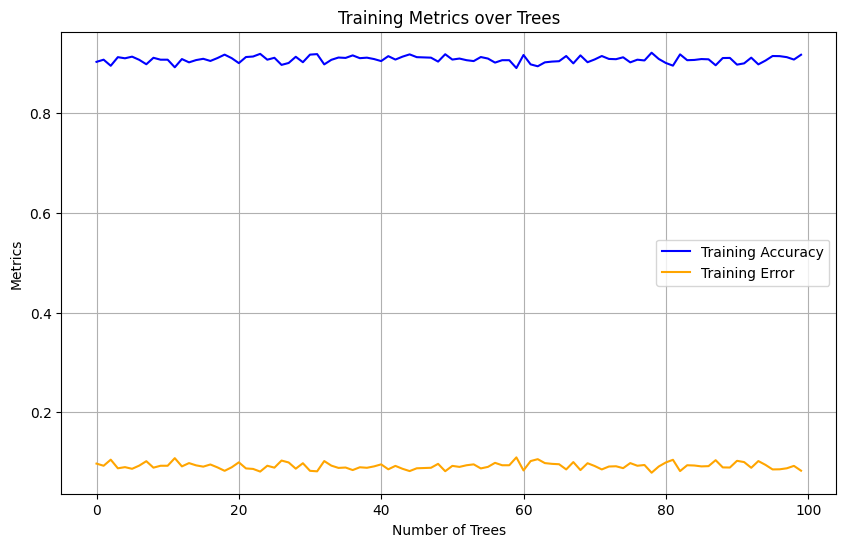

Accuracy: 0.8402848423194303


In [87]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, matthews_corrcoef
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# Assuming `preprocessed_texts` contains preprocessed review texts and `targets` contains sentiment labels

# Concatenate preprocessed_texts into a single string
full_texts = [' '.join(text) for text in preprocessed_texts]

# Convert text data into numerical features using CountVectorizer
vectorizer = CountVectorizer(max_features=10000)
X = vectorizer.fit_transform(full_texts).toarray()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, targets, test_size=0.2, random_state=42)

# Define and train the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
mcc = matthews_corrcoef(y_test, y_pred)
npv = tn / (tn + fn)
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall/Sensitivity: {recall}')
print(f'F1-Score: {f1}')
print(f'Specificity: {specificity}')
print(f'MCC: {mcc}')
print(f'NPV: {npv}')
print(f'FPR: {fpr}')
print(f'FNR: {fnr}')

# ROC Curve
y_pred_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

full_texts = [' '.join(text) for text in preprocessed_texts]

# Convert text data into numerical features using CountVectorizer
vectorizer = CountVectorizer(max_features=10000)
X = vectorizer.fit_transform(full_texts).toarray()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, targets, test_size=0.2, random_state=42)

# Define and train the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
history = model.fit(X_train, y_train)

# Plot training metrics (accuracy and error) over the number of trees
plt.figure(figsize=(10, 6))

n_trees = len(model.estimators_)
train_accuracy = [estimator.score(X_train, y_train) for estimator in model.estimators_]
train_error = [1 - acc for acc in train_accuracy]

plt.plot(range(n_trees), train_accuracy, label='Training Accuracy', color='blue')
plt.plot(range(n_trees), train_error, label='Training Error', color='orange')

plt.xlabel('Number of Trees')
plt.ylabel('Metrics')
plt.title('Training Metrics over Trees')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')


# 3 SVM 

C:\Users\KEVIN\AppData\Local\Temp\ipykernel_4696\3864860470.py:44: RuntimeWarning: invalid value encountered in scalar divide
  npv = TN / (TN + FN)


Accuracy: 0.8107833163784334
Precision: 0.8107833163784334
Recall (Sensitivity): 1.0
Specificity: 0.0
F1-Score: 0.895505617977528
MCC: 0.0
NPV: nan
FPR: 1.0
FNR: 0.0


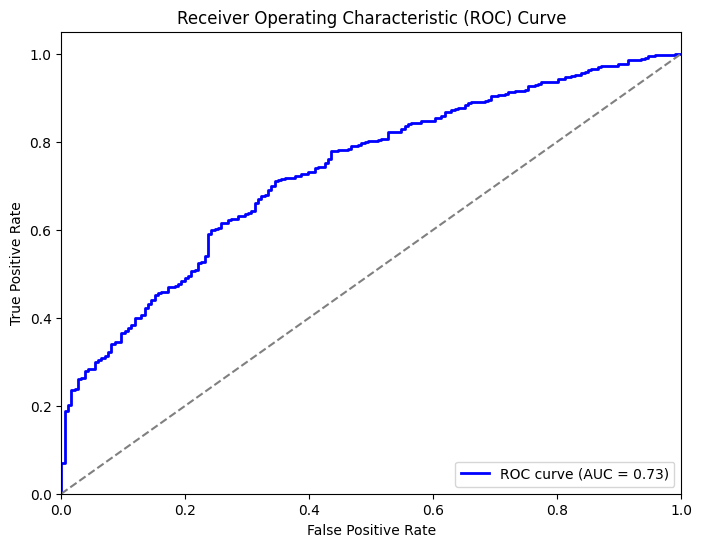

In [110]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, matthews_corrcoef
import matplotlib.pyplot as plt

# Assuming `df` is a Pandas DataFrame that has already been defined and includes a 'target' column
# Example: df = pd.read_csv('reviews.csv')

# Assuming `selected_features` and `targets` are already defined

# Split the data into training and testing sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(selected_features, targets, test_size=0.2, random_state=42)

# Initialize SVM classifier with probability estimates enabled
svm_model = SVC(probability=True)

# Train the SVM classifier on the training data
svm_model.fit(X_train, y_train)

# Predict the labels of the test set
y_pred = svm_model.predict(X_test)

# Calculate accuracy on the test set
accuracy = accuracy_score(y_test, y_pred)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# True positives, false positives, true negatives, false negatives
TP = conf_matrix[1, 1]
FP = conf_matrix[0, 1]
TN = conf_matrix[0, 0]
FN = conf_matrix[1, 0]

# Calculate classification metrics
precision = TP / (TP + FP)
recall = TP / (TP + FN)
specificity = TN / (TN + FP)
f1_score = 2 * (precision * recall) / (precision + recall)
mcc = matthews_corrcoef(y_test, y_pred)
npv = TN / (TN + FN)
fpr = FP / (FP + TN)
fnr = FN / (FN + TP)

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall (Sensitivity):", recall)
print("Specificity:", specificity)
print("F1-Score:", f1_score)
print("MCC:", mcc)
print("NPV:", npv)
print("FPR:", fpr)
print("FNR:", fnr)


# Plot ROC curve
y_pred_proba = svm_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


# 4 Decision Tree

Test Accuracy: 0.6805696846388606
Precision: 0.8108108108108109
Recall/Sensitivity: 0.7904642409033877
F1-Score: 0.8005082592121983
Specificity: 0.20967741935483872
MCC: 0.00013632940596504153
NPV: 0.18932038834951456
FPR: 0.7903225806451613
FNR: 0.2095357590966123


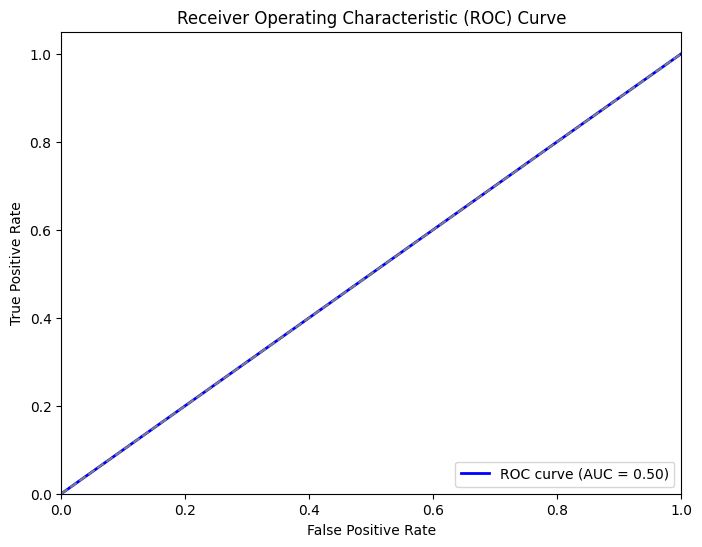

In [107]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, matthews_corrcoef
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.tree import DecisionTreeClassifier


# Prepare data
max_words = 10000  # Maximum number of words to be used (most frequent)
max_len = 100  # Max length of review (in words)

# Assuming `preprocessed_texts` contains preprocessed review texts and `targets` contains sentiment labels
X_train, X_test, y_train, y_test = train_test_split(preprocessed_texts, targets, test_size=0.2, random_state=42)

# Tokenization and Vectorization
tokenizer = Tokenizer(num_words=max_words, lower=True)
tokenizer.fit_on_texts(X_train)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_len)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_len)

# Define and train the Decision Tree model
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train_padded, y_train)

# Evaluate the model
accuracy = decision_tree.score(X_test_padded, y_test)
print(f'Test Accuracy: {accuracy}')

# Predictions
y_pred = decision_tree.predict(X_test_padded)

# Additional Metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
mcc = matthews_corrcoef(y_test, y_pred)
npv = tn / (tn + fn)
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)

print(f'Precision: {precision}')
print(f'Recall/Sensitivity: {recall}')
print(f'F1-Score: {f1}')
print(f'Specificity: {specificity}')
print(f'MCC: {mcc}')
print(f'NPV: {npv}')
print(f'FPR: {fpr}')
print(f'FNR: {fnr}')

from sklearn.metrics import roc_curve, auc

# Calculate class probabilities
y_prob = decision_tree.predict_proba(X_test_padded)[:, 1]  # Probability of positive class

# Calculate false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



# Classification model (70/30)

# 1.LSTM 

Epoch 1/5


C:\Users\KEVIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.7585 - loss: 0.5706 - val_accuracy: 0.8061 - val_loss: 0.4663
Epoch 2/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 0.8088 - loss: 0.4320 - val_accuracy: 0.8563 - val_loss: 0.3409
Epoch 3/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9054 - loss: 0.2602 - val_accuracy: 0.8651 - val_loss: 0.3158
Epoch 4/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - accuracy: 0.9305 - loss: 0.1870 - val_accuracy: 0.8563 - val_loss: 0.3493
Epoch 5/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.9580 - loss: 0.1415 - val_accuracy: 0.8576 - val_loss: 0.3591
Epoch 5: early stopping
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8577 - loss: 0.3606
Test Loss: 0.3591063916683197
Test Accuracy: 0.8576270937919617
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Precision: 0.8944399677679291
Recall/Sensitivity: 0.9335576114381834
F1-Score: 0.9135802469135802
Specificity: 0.541958041958042
MCC: 0.5145705682617466
NPV: 0.6623931623931

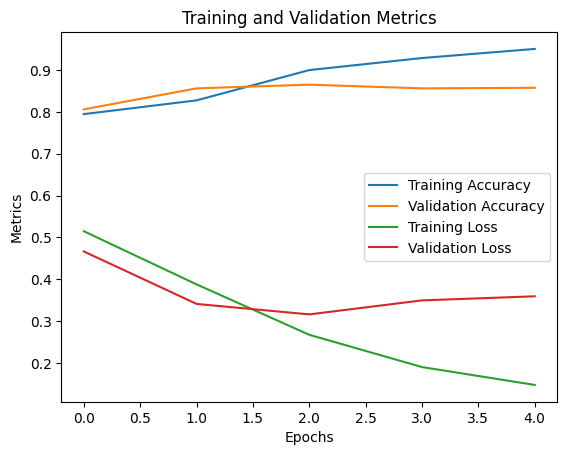

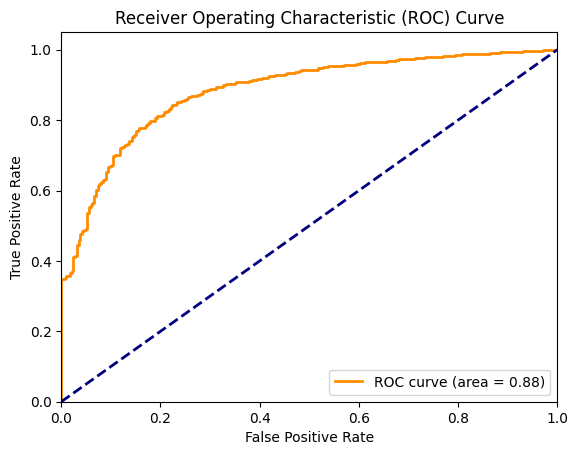

In [90]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, matthews_corrcoef
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# Prepare data for LSTM model
max_words = 10000  # Maximum number of words to be used (most frequent)
max_len = 100  # Max length of review (in words)

# Assuming `preprocessed_texts` contains preprocessed review texts and `targets` contains sentiment labels
tokenizer = Tokenizer(num_words=max_words, lower=True)
tokenizer.fit_on_texts(preprocessed_texts)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(preprocessed_texts)
padded_sequences = pad_sequences(sequences, maxlen=max_len)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, targets, test_size=0.3, random_state=42)

# Define the LSTM model
embedding_dim = 100

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_len))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])



# Train the model
batch_size = 64
epochs = 5
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

history = model.fit(X_train, np.array(y_train), 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    validation_data=(X_test, np.array(y_test)),
                    callbacks=[early_stop])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, np.array(y_test))
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

# Predictions
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Additional Metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
mcc = matthews_corrcoef(y_test, y_pred)
npv = tn / (tn + fn)
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)

print(f'Precision: {precision}')
print(f'Recall/Sensitivity: {recall}')
print(f'F1-Score: {f1}')
print(f'Specificity: {specificity}')
print(f'MCC: {mcc}')
print(f'NPV: {npv}')
print(f'FPR: {fpr}')
print(f'FNR: {fnr}')

# Plotting training/validation epochs graph
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Metrics')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


# 2. Random forest classifier 

Evaluation Metrics:
Accuracy: 0.8067796610169492
Precision: 0.8192090395480226
Recall (Sensitivity): 0.975609756097561
F1-Score: 0.8905950095969289
Specificity: 0.1048951048951049
MCC: 0.16241959223289398
NPV: 0.5084745762711864
FPR: 0.8951048951048951
FNR: 0.024390243902439025


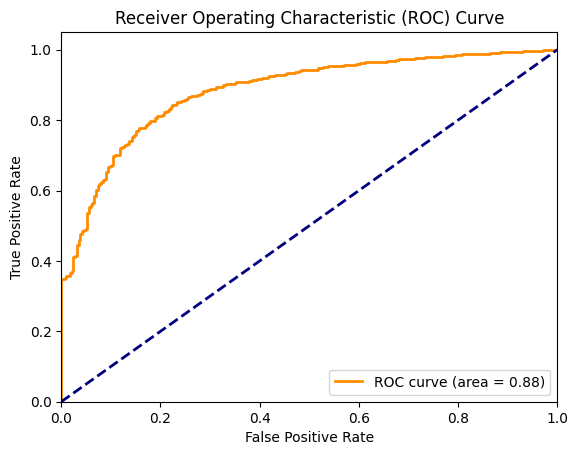

In [101]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, RocCurveDisplay

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(selected_features, targets, test_size=0.3, random_state=42)

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training data
rf_classifier.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = rf_classifier.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Calculate specificity and sensitivity
tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

# Calculate Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(y_test, y_pred)

# Calculate Negative Predictive Value (NPV)
npv = tn / (tn + fn)

# Calculate False Positive Rate (FPR) and False Negative Rate (FNR)
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)

# Print evaluation metrics
print("Evaluation Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall (Sensitivity):", recall)
print("F1-Score:", f1)
print("Specificity:", specificity)
print("MCC:", mcc)
print("NPV:", npv)
print("FPR:", fpr)
print("FNR:", fnr)



# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



# 3 SVM

C:\Users\KEVIN\AppData\Local\Temp\ipykernel_4696\4233232281.py:44: RuntimeWarning: invalid value encountered in scalar divide
  npv = TN / (TN + FN)


Accuracy: 0.8061016949152542
Precision: 0.8061016949152542
Recall (Sensitivity): 1.0
Specificity: 0.0
F1-Score: 0.8926426426426426
MCC: 0.0
NPV: nan
FPR: 1.0
FNR: 0.0


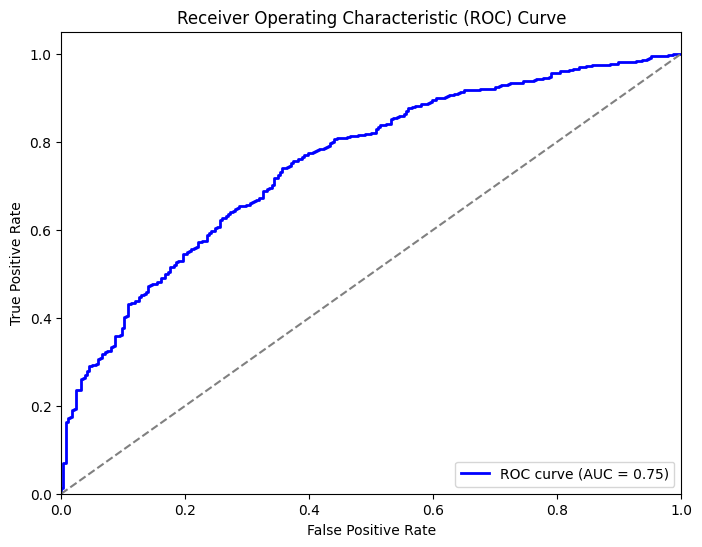

In [104]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, matthews_corrcoef
import matplotlib.pyplot as plt

# Assuming `df` is a Pandas DataFrame that has already been defined and includes a 'target' column
# Example: df = pd.read_csv('reviews.csv')

# Assuming `selected_features` and `targets` are already defined

# Split the data into training and testing sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(selected_features, targets, test_size=0.3, random_state=42)

# Initialize SVM classifier with probability estimates enabled
svm_model = SVC(probability=True)

# Train the SVM classifier on the training data
svm_model.fit(X_train, y_train)

# Predict the labels of the test set
y_pred = svm_model.predict(X_test)

# Calculate accuracy on the test set
accuracy = accuracy_score(y_test, y_pred)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# True positives, false positives, true negatives, false negatives
TP = conf_matrix[1, 1]
FP = conf_matrix[0, 1]
TN = conf_matrix[0, 0]
FN = conf_matrix[1, 0]

# Calculate classification metrics
precision = TP / (TP + FP)
recall = TP / (TP + FN)
specificity = TN / (TN + FP)
f1_score = 2 * (precision * recall) / (precision + recall)
mcc = matthews_corrcoef(y_test, y_pred)
npv = TN / (TN + FN)
fpr = FP / (FP + TN)
fnr = FN / (FN + TP)

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall (Sensitivity):", recall)
print("Specificity:", specificity)
print("F1-Score:", f1_score)
print("MCC:", mcc)
print("NPV:", npv)
print("FPR:", fpr)
print("FNR:", fnr)


# Plot ROC curve
y_pred_proba = svm_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


# 4. Decision Tree

Test Accuracy: 0.6766101694915254
Precision: 0.812829525483304
Recall/Sensitivity: 0.7779646761984861
F1-Score: 0.7950150408250967
Specificity: 0.25524475524475526
MCC: 0.031271542429583465
NPV: 0.2166172106824926
FPR: 0.7447552447552448
FNR: 0.2220353238015139


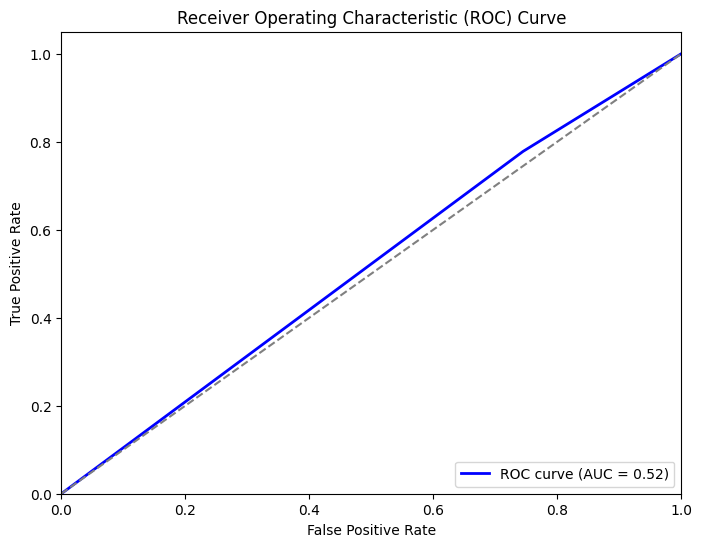

In [106]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, matthews_corrcoef
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.tree import DecisionTreeClassifier


# Prepare data
max_words = 10000  # Maximum number of words to be used (most frequent)
max_len = 100  # Max length of review (in words)

# Assuming `preprocessed_texts` contains preprocessed review texts and `targets` contains sentiment labels
X_train, X_test, y_train, y_test = train_test_split(preprocessed_texts, targets, test_size=0.3, random_state=42)

# Tokenization and Vectorization
tokenizer = Tokenizer(num_words=max_words, lower=True)
tokenizer.fit_on_texts(X_train)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_len)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_len)

# Define and train the Decision Tree model
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train_padded, y_train)

# Evaluate the model
accuracy = decision_tree.score(X_test_padded, y_test)
print(f'Test Accuracy: {accuracy}')

# Predictions
y_pred = decision_tree.predict(X_test_padded)

# Additional Metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
mcc = matthews_corrcoef(y_test, y_pred)
npv = tn / (tn + fn)
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)

print(f'Precision: {precision}')
print(f'Recall/Sensitivity: {recall}')
print(f'F1-Score: {f1}')
print(f'Specificity: {specificity}')
print(f'MCC: {mcc}')
print(f'NPV: {npv}')
print(f'FPR: {fpr}')
print(f'FNR: {fnr}')


from sklearn.metrics import roc_curve, auc

# Calculate class probabilities
y_prob = decision_tree.predict_proba(X_test_padded)[:, 1]  # Probability of positive class

# Calculate false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


# Visulaizing overall review of our PRODUCT 

154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


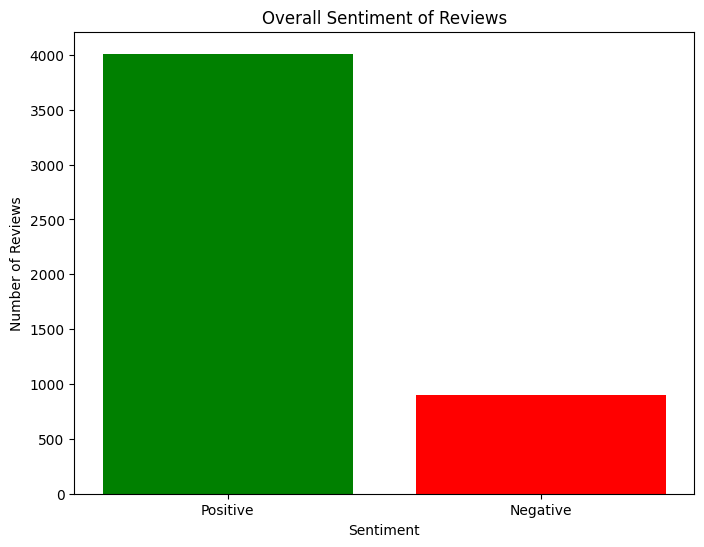

In [50]:
# Predict sentiment labels probabilities for all data
all_pred_prob = model.predict(padded_sequences)
all_pred = (all_pred_prob > 0.5).astype(int).ravel()

# Count positive and negative sentiments
positive_count = np.sum(all_pred)
negative_count = len(all_pred) - positive_count

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(['Positive', 'Negative'], [positive_count, negative_count], color=['green', 'red'])
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.title('Overall Sentiment of Reviews')
plt.show()


# Model comparision

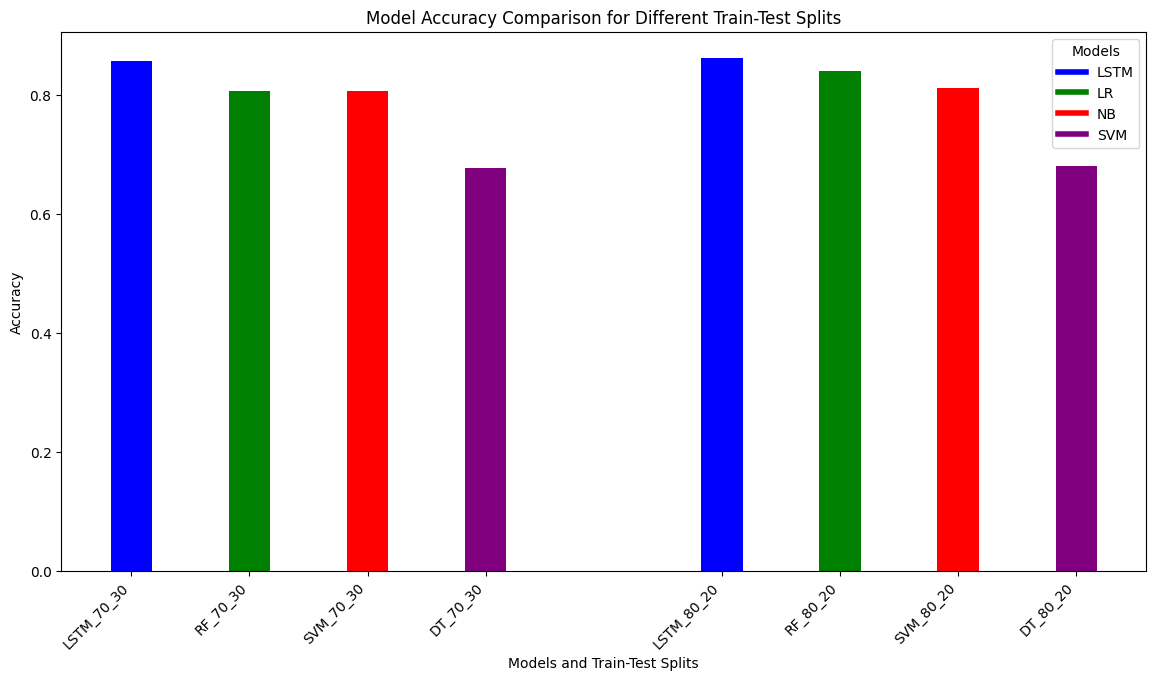

In [112]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models_70_30 = ['LSTM_70_30', 'RF_70_30', 'SVM_70_30', 'DT_70_30']
accuracy_70_30 = [0.8576270937919617,0.8067796610169492,0.8061016949152542,0.6766101694915254]

models_80_20 = ['LSTM_80_20', 'RF_80_20', 'SVM_80_20', 'DT_80_20']
accuracy_80_20 = [0.8626652956008911,0.8402848423194303,0.8107833163784334,0.6805696846388606]

# Combining data
models = models_70_30 + models_80_20
accuracy = accuracy_70_30 + accuracy_80_20

# Assigning colors to each model split
colors_70_30 = ['blue', 'green', 'red', 'purple']
colors_80_20 = ['blue', 'green', 'red', 'purple']
colors = colors_70_30 + colors_80_20

# Define bar width and positions
bar_width = 0.35
index_70_30 = np.arange(len(models_70_30))
index_80_20 = index_70_30 + len(models_70_30) + 1  # Adding a gap between the two groups

# Creating the bar plot
plt.figure(figsize=(14, 7))

# Plotting the bars with labels for legend
bars_70_30 = plt.bar(index_70_30, accuracy_70_30, bar_width, color=colors_70_30)
bars_80_20 = plt.bar(index_80_20, accuracy_80_20, bar_width, color=colors_80_20)

# Adding title and labels
plt.title('Model Accuracy Comparison for Different Train-Test Splits')
plt.xlabel('Models and Train-Test Splits')
plt.ylabel('Accuracy')

# Adjusting x-axis labels
plt.xticks(np.concatenate([index_70_30, index_80_20]),
           models_70_30 + models_80_20, rotation=45, ha='right')

# Creating custom legends
legend_labels = ['LSTM', 'LR', 'NB', 'SVM']
legend_colors = ['blue', 'green', 'red', 'purple']
legend_handles = [plt.Line2D([0], [0], color=color, lw=4) for color in legend_colors]
plt.legend(legend_handles, legend_labels, title='Models')

# Showing the plot
plt.show()